# Convoluted Neural Network (CNN)

## 卷积

卷积神经网络主要用于图像和计算机视觉方面，尤其擅长处理$图像数据$，在序列数据、图结构数据、推荐系统上也可以发挥作用

使用$[\mathbf{X}]_{i, j}$和$[\mathbf{H}]_{i, j}$分别表示输入图像和隐藏表示中位置（$i$,$j$）处的像素。
为了使每个隐藏神经元都能接收到每个输入像素的信息，我们将参数从权重矩阵（如同我们先前在多层感知机中所做的那样）替换为四阶权重张量$\mathsf{W}$。假设$\mathbf{U}$包含偏置参数，我们可以将全连接层形式化地表示为

$$\begin{aligned} \left[\mathbf{H}\right]_{i, j} &= [\mathbf{U}]_{i, j} + \sum_k \sum_l[\mathsf{W}]_{i, j, k, l}  [\mathbf{X}]_{k, l}\\ &=  [\mathbf{U}]_{i, j} +
\sum_a \sum_b [\mathsf{V}]_{i, j, a, b}  [\mathbf{X}]_{i+a, j+b}.\end{aligned}$$

由于$平移不变性$，上式可以化为：
$$[\mathbf{H}]_{i, j} = u + \sum_a\sum_b [\mathbf{V}]_{a, b} [\mathbf{X}]_{i+a, j+b}.$$
这就是*卷积*（convolution）

又由于$局部性$，我们的训练时，收集信息不应偏离到距离（i，j）太远的地方。
这意味着在$|a|> \Delta$或$|b| > \Delta$的范围之外，我们可以设置$[\mathbf{V}]_{a, b} = 0$。因此，我们可以将$[\mathbf{H}]_{i, j}$重写为

$$[\mathbf{H}]_{i, j} = u + \sum_{a = -\Delta}^{\Delta} \sum_{b = -\Delta}^{\Delta} [\mathbf{V}]_{a, b}  [\mathbf{X}]_{i+a, j+b}.$$

我们称上式为一个$卷积层$，包含卷积层的神经网络就是卷积神经网络


$\mathbf{V}$被称为*卷积核*（convolution kernel）或者*滤波器*（filter），亦或简单地称之为该卷积层的*权重*，通常该权重是可学习的参数。

## 互相关运算

不同于数学中的卷积运算，这里所谓的卷积运算更像是互相关运算。


首先，我们暂时忽略通道（第三维）这一情况，看看如何处理二维图像数据和隐藏表示。在 :numref:`fig_correlation`中，输入是高度为$3$、宽度为$3$的二维张量（即形状为$3 \times 3$）。卷积核的高度和宽度都是$2$，而卷积核窗口（或卷积窗口）的形状由内核的高度和宽度决定（即$2 \times 2$）。



![二维互相关运算。阴影部分是第一个输出元素，以及用于计算输出的输入张量元素和核张量元素：$0\times0+1\times1+3\times2+4\times3=19$.](../../img/correlation.svg)

类似于滑动窗口的算法，这里的核函数窗口在输入张量上滑动，并将输出存储到输出张量中

然而，为了保证有足够的空间移动卷积核，我们有时候会在图像边界填充0，从而保证输出大小不变。


下面我们简单的演示一下卷积操作

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
def corr2d(X,K):
    """2d correlation"""
    h,w = K.shape
    Y = torch.zeros((X.shape[0] - h + 1,X.shape[1]-w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            Y[i,j] = (X[i:i+h,j:j+w]*K).sum()
    return Y

In [3]:
X = torch.tensor([[0.0,1.0,2.0],[3.0,4.0,5.0],[6.0,7.0,8.0]])
K = torch.tensor([[0.0,1.0],[2.0,3.0]])
corr2d(X,K)

tensor([[19., 25.],
        [37., 43.]])

接着我们实现一个卷积层

In [5]:
class Conv2D(nn.Module):
    def __init__(self,kernel_size):
        super().__init__()
        self.weight = nn.Parameter(torch.rand(kernel_size))
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self,x):
        return corr2d(x,self.weight)+self.bias

然后应用其进行图像中目标的边缘检测

In [6]:
X = torch.ones((6,8))
X[:,2:6] = 0
X

tensor([[1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.],
        [1., 1., 0., 0., 0., 0., 1., 1.]])

In [7]:
K = torch.tensor([[1.0,-1.0]])

In [8]:
Y = corr2d(X,K)
Y

tensor([[ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.],
        [ 0.,  1.,  0.,  0.,  0., -1.,  0.]])

In [9]:
corr2d(X.t(),K)

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [10]:
conv2d = nn.Conv2d(1,1,kernel_size=(1,2),bias = False)

X = X.reshape((1,1,6,8))
Y = Y.reshape((1,1,6,7))
lr = 3e-2

for i in range(10):
    Y_hat = conv2d(X)
    l = (Y_hat-Y)**2
    conv2d.zero_grad()
    l.sum().backward()

    conv2d.weight.data[:]-=lr*conv2d.weight.grad
    if(i+1)%2 == 0:
        print(f"Epoch {i+1}, Loss {l.sum():.4f}")

Epoch 2, Loss 8.7629
Epoch 4, Loss 2.0441
Epoch 6, Loss 0.5780
Epoch 8, Loss 0.1933
Epoch 10, Loss 0.0719


In [11]:
conv2d.weight.data.reshape((1,2))

tensor([[ 0.9602, -1.0135]])

## 影响输出的因素

### 输入和卷积核


假设输入形状为$n_h\times n_w$，卷积核形状为$k_h\times k_w$，那么输出形状将是$(n_h-k_h+1) \times (n_w-k_w+1)$。
因此，卷积的输出形状取决于输入形状和卷积核的形状。

### 填充和步幅

例如，我们将$3 \times 3$输入填充到$5 \times 5$，那么它的输出就增加为$4 \times 4$。阴影部分是第一个输出元素以及用于输出计算的输入和核张量元素：
$0\times0+0\times1+0\times2+0\times3=0$。

![带填充的二维互相关。](../../img/conv-pad.svg)

卷积神经网络中卷积核的高度和宽度通常为奇数，例如1、3、5或7。
选择奇数的好处是，保持空间维度的同时，我们可以在顶部和底部填充相同数量的行，在左侧和右侧填充相同数量的列。

In [12]:
import torch
from torch import nn

def comp_conv2d(conv2d,X):
    X = X.reshape((1,1)+X.shape)
    Y = conv2d(X)
    return Y.reshape(Y.shape[2:])

conv2d = nn.Conv2d(1,1,kernel_size=3,padding=1)
X = torch.rand(size = (8,8))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

In [13]:
conv2d = nn.Conv2d(1,1,kernel_size=(5,3),padding=(2,1))
comp_conv2d(conv2d,X).shape

torch.Size([8, 8])

有时候为了高效计算或是缩减采样次数，卷积窗口可以跳过中间位置，每次滑动多个元素。

我们将每次滑动元素的数量称为*步幅*（stride）。

## 多输入输出通道

### 多输入

假设输入的通道数为$c_i$，那么卷积核的输入通道数也需要为$c_i$。如果卷积核的窗口形状是$k_h\times k_w$，那么当$c_i=1$时，我们可以把卷积核看作形状为$k_h\times k_w$的二维张量。

当$c_i>1$时，我们卷积核的每个输入通道将包含形状为$k_h\times k_w$的张量。将这些张量$c_i$连结在一起可以得到形状为$c_i\times k_h\times k_w$的卷积核。由于输入和卷积核都有$c_i$个通道，我们可以对每个通道输入的二维张量和卷积核的二维张量进行互相关运算，再对通道求和（将$c_i$的结果相加）得到二维张量。这是多通道输入和多输入通道卷积核之间进行二维互相关运算的结果。

![两个输入通道的互相关计算。](../../img/conv-multi-in.svg)

下面给出代码实现:

In [14]:
import torch 
from d2l import torch as d2l

In [15]:
def corr2d_multi_in(X,K):
    return sum(d2l.corr2d(x,k) for x,k in zip(X,K))

In [16]:
X = torch.tensor([[[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]],
               [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0], [7.0, 8.0, 9.0]]])
K = torch.tensor([[[0.0, 1.0], [2.0, 3.0]], [[1.0, 2.0], [3.0, 4.0]]])

corr2d_multi_in(X, K)

tensor([[ 56.,  72.],
        [104., 120.]])

### 多输出

随着神经网络层数的加深，我们常会增加输出通道的维数，通过减少空间分辨率以获得更大的通道深度。直观地说，我们可以将每个通道看作对不同特征的响应。而现实可能更为复杂一些，因为每个通道不是独立学习的，而是为了共同使用而优化的。因此，多输出通道并不仅是学习多个单通道的检测器。

用$c_i$和$c_o$分别表示输入和输出通道的数目，并让$k_h$和$k_w$为卷积核的高度和宽度。为了获得多个通道的输出，我们可以为每个输出通道创建一个形状为$c_i\times k_h\times k_w$的卷积核张量，这样卷积核的形状是$c_o\times c_i\times k_h\times k_w$。在互相关运算中，每个输出通道先获取所有输入通道，再以对应该输出通道的卷积核计算出结果。

代码实现如下：

In [17]:
def corr2d_multi_in_out(X,K):
    return torch.stack([corr2d_multi_in(X,k)for k in K],0)

In [18]:
K = torch.stack((K,K+1,K+2),0)
K.shape

torch.Size([3, 2, 2, 2])

In [19]:
corr2d_multi_in_out(X,K)

tensor([[[ 56.,  72.],
         [104., 120.]],

        [[ 76., 100.],
         [148., 172.]],

        [[ 96., 128.],
         [192., 224.]]])

## 1X1卷积层

显然1X1的卷积层对相邻特征的提取并没有什么实际作用，它更多的是对通道进行计算

下面对全连接层实现1X1卷积：

In [20]:
def corr2d_multi_in_out_1x1(X, K):
    c_i, h, w = X.shape
    c_o = K.shape[0]
    X = X.reshape((c_i, h * w))
    K = K.reshape((c_o, c_i))
    # 全连接层中的矩阵乘法
    Y = torch.matmul(K, X)
    return Y.reshape((c_o, h, w))

In [21]:
X = torch.normal(0, 1, (3, 3, 3))
K = torch.normal(0, 1, (2, 3, 1, 1))

In [22]:
Y1 = corr2d_multi_in_out_1x1(X, K)
Y2 = corr2d_multi_in_out(X, K)
assert float(torch.abs(Y1 - Y2).sum()) < 1e-6

不难看出，1X1卷积层的主要作用，还是在**调整通道数量**和**控制模型复杂度**上

## 汇聚层

目的：降低卷积层对位置的敏感性，同时降低对空间降采样表示的敏感性。

不同于卷积层中的输入与卷积核之间的互相关计算，汇聚层不包含参数。
相反，池运算是确定性的，我们通常计算汇聚窗口中所有元素的最大值或平均值。这些操作分别称为*最大汇聚层*（maximum pooling）和*平均汇聚层*（average pooling）。

下面给出代码实现：

In [23]:
import torch
from torch import nn 
from d2l import torch as d2l

In [24]:
def pool2d(X,pool_size,mode='max'):
    p_h,p_w = pool_size
    Y = torch.zeros((X.shape[0]-p_h+1,X.shape[1]-p_w+1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            if mode == 'max':
                Y[i,j] = X[i:i+p_h,j:j+p_w].max()
            elif mode == 'avg':
                Y[i,j] = X[i:i+p_h,j:j+p_w].mean()
    return Y

In [25]:
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
pool2d(X, (2, 2))

tensor([[4., 5.],
        [7., 8.]])

In [26]:
pool2d(X,(2,2),'avg')

tensor([[2., 3.],
        [5., 6.]])

In [27]:
X = torch.arange(16, dtype=torch.float32).reshape((1, 1, 4, 4))
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])

In [28]:
pool2d = nn.MaxPool2d(3)
pool2d(X)

tensor([[[[10.]]]])

In [29]:
pool2d = nn.MaxPool2d(3,padding=1,stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [31]:
pool2d = nn.MaxPool2d((2,3),stride=(2,3),padding=(0,1))
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]]]])

In [32]:
X = torch.cat((X, X + 1), 1)
X

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]],

         [[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])

In [33]:
pool2d = nn.MaxPool2d(3, padding=1, stride=2)
pool2d(X)

tensor([[[[ 5.,  7.],
          [13., 15.]],

         [[ 6.,  8.],
          [14., 16.]]]])

## LeNet

总体来看，**LeNet（LeNet-5）由两个部分组成：**

* 卷积编码器：由两个卷积层组成;
* 全连接层密集块：由三个全连接层组成。

每个卷积块中的基本单元是一个卷积层、一个sigmoid激活函数和平均汇聚层。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

net = nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(16*5*5,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)

    # 这里还可以使用一层高斯激活,此处省略
)

In [2]:
X = torch.rand(size=(1,1,28,28),dtype = torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 6, 28, 28])
Sigmoid output shape:	 torch.Size([1, 6, 28, 28])
AvgPool2d output shape:	 torch.Size([1, 6, 14, 14])
Conv2d output shape:	 torch.Size([1, 16, 10, 10])
Sigmoid output shape:	 torch.Size([1, 16, 10, 10])
AvgPool2d output shape:	 torch.Size([1, 16, 5, 5])
Flatten output shape:	 torch.Size([1, 400])
Linear output shape:	 torch.Size([1, 120])
Sigmoid output shape:	 torch.Size([1, 120])
Linear output shape:	 torch.Size([1, 84])
Sigmoid output shape:	 torch.Size([1, 84])
Linear output shape:	 torch.Size([1, 10])


In [3]:
batch_size = 256
train_iter,test_iter = d2l.load_data_fashion_mnist(batch_size)

100.0%


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100.0%


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100.0%

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [4]:
def evaluate_accuracy_gpu(net,data_iter,device =None):
    """Evaluate the accuracy of a model on the given dataset using GPU."""
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)  # num_correct, num_examples
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # Required for BERT Fine-tuning (to be covered later)
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0]/metric[1]

在进行正向和反向传播之前，我们需要将每一小批量数据移动到我们指定的设备（例如GPU）上。

我们使用Xavier随机初始化模型参数。

同时，与全连接层一样，我们使用交叉熵损失函数和小批量随机梯度下降。

In [6]:
# codes here are copied from the book
# It's too complex to rewite them by myself.....
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

loss 0.468, train acc 0.823, test acc 0.811
74132.5 examples/sec on cuda:0


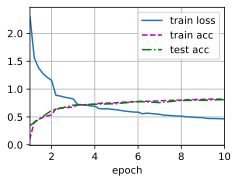

In [7]:
lr = 0.9
num_epochs = 10

train_ch6(net,train_iter,test_iter,num_epochs,lr,d2l.try_gpu())